<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/2022/Oct/graph%20classification%20on%20MUTAG%20using%20the%20Weisfeiler-Lehman%20subtree%20kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install grakel --quiet
!pip install dgl --quiet

     |████████████████████████████████| 4.9 MB 2.1 MB/s 
     |████████████████████████████████| 281 kB 40.1 MB/s 


# Using Grakel library

In [60]:
from grakel import GraphKernel
from grakel import Graph
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel import RandomWalk,RandomWalkLabeled
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram

In [61]:
#188 mutagenic aromatic and heteroaromatic nitro compounds, 
#and the task is to predict whether or not each chemical compound has mutagenic effect 
#on the Gram-negative bacterium Salmonella typhimurium.
MUTAG = fetch_dataset("MUTAG", verbose=False)
G, y = MUTAG.data, MUTAG.target

In [62]:
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)


In [63]:
gk = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)
K_train = gk.fit_transform(G_train)
K_test = gk.transform(G_test)

# Uses the SVM classifier to perform classification
clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", str(round(acc*100, 2)) + "%")

Accuracy: 89.47%


fit_transform

1) fit 
: calls: self initialise and parse_input
2)calculate kernel matrix
3) get the diagonal
4) normalise if normalisation required 


## Kernel between 2  molecules graphs 

In [27]:
H2O_adjacency = [[0, 1, 1], [1, 0, 0], [1, 0, 0]]
H2O_node_labels = {0: 'O', 1: 'H', 2: 'H'}
H2O = Graph(initialization_object=H2O_adjacency, node_labels=H2O_node_labels)
H3O_adjacency = [[0, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
H3O_node_labels = {0: 'O', 1: 'H', 2: 'H', 3:'H'}
H3O = Graph(initialization_object=H3O_adjacency, node_labels=H3O_node_labels)

The shortest path kernel which counts the number of shortest paths of equal length in two graphs 

In [37]:

sp_kernel =  WeisfeilerLehman()
#compute the graph representtaion between water and itself
sp_kernel.fit_transform([H2O])
#compute the kernel value between the graoh representation of water and hydronium
sp_kernel.transform([H3O])

array([[13.]])

## Apply normalisation

In [38]:
sp_kernel =  WeisfeilerLehman(normalize=True )
#compute the graph representtaion between water and itself
sp_kernel.fit_transform([H2O])
#compute the kernel value between the graoh representation of water and hydronium
sp_kernel.transform([H3O])

array([[0.30641294]])

#Function to work with NX graphs inspired by Grakel

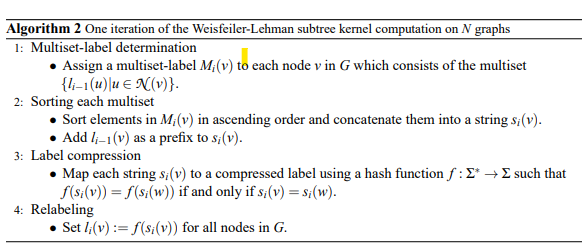

https://www.jmlr.org/papers/volume12/shervashidze11a/shervashidze11a.pdf

In [64]:
def compare(g_1, g_2, verbose=False,nodelist=None,kernel_type='geometric'):
        """Compute the kernel value (similarity) between two graphs.
        Parameters
        ----------
        g1 : networkx.Graph
            First graph.
        g2 : networkx.Graph
            Second graph.
        Returns
        -------
        k : The similarity value between g1 and g2.
        """
        # Diagonal superior matrix of the floyd warshall shortest
        # paths:
        A = nx.to_numpy_matrix(g_1,nodelist=nodelist, nonedge=0, multigraph_weight=min,weight='weight')
        B= nx.to_numpy_matrix(g_2,nodelist=nodelist,nonedge=0, multigraph_weight=min,weight='weight')
        n,m = A.shape
        p,q=B.shape
        XY = np.kron(A, B)
        #print(XY.shape)
        # XY is a square matrix
        s = XY.shape[0]
        lamda=0.1
        if kernel_type=='geometric':
           S = inv(np.identity(s) - lamda*XY).T
        elif  kernel_type=='exponential': 
           S = expm(lamda*XY).T
        return np.sum(S)




In [65]:
np.zeros((3, 2, 2))

array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]])

In [54]:
x=dgl.DGLGraph(G1)
np.zeros(x.number_of_nodes())

/usr/local/lib/python3.7/dist-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


array([0., 0., 0.])

In [58]:
len(G1)

3

## Testing to see if we get a similar score using custom implementation 

In [66]:
from six import iteritems
from six import itervalues

In [35]:
def get_nxgraph_from_adjanecy_matrix(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    all_rows = range(0, adjacency_matrix.shape[0])
    for n in all_rows:
        gr.add_node(n)
    gr.add_edges_from(edges)
    gr.add_edges_from(edges)
    return gr


In [49]:
G1=get_nxgraph_from_adjanecy_matrix(np.array(H2O_adjacency))
G2=get_nxgraph_from_adjanecy_matrix(np.array(H3O_adjacency))


In [40]:
A = nx.to_numpy_matrix(G1,nodelist=None, nonedge=0, multigraph_weight=min,weight='weight')
B= nx.to_numpy_matrix(G2,nodelist=None,nonedge=0, multigraph_weight=min,weight='weight')
A

matrix([[0., 1., 1.],
        [1., 0., 0.],
        [1., 0., 0.]])

IndentationError: ignored

In [75]:
"""The weisfeiler lehman kernel :cite:`shervashidze2011weisfeiler`."""
# Author: Ioannis Siglidis <y.siglidis@gmail.com>
# License: BSD 3 clause
import collections
import warnings

import numpy as np
import joblib

from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted

from grakel.graph import Graph
from grakel.kernels import Kernel
from grakel.kernels.vertex_histogram import VertexHistogram

# Python 2/3 cross-compatibility import
from six import iteritems
from six import itervalues


class WeisfeilerLehman(Kernel):
    """Compute the Weisfeiler Lehman Kernel.

     See :cite:`shervashidze2011weisfeiler`.

    Parameters
    ----------
    n_iter : int, default=5
        The number of iterations.

    base_graph_kernel : `grakel.kernels.Kernel` or tuple, default=None
        If tuple it must consist of a valid kernel object and a
        dictionary of parameters. General parameters concerning
        normalization, concurrency, .. will be ignored, and the
        ones of given on `__init__` will be passed in case it is needed.
        Default `base_graph_kernel` is `VertexHistogram`.

    Attributes
    ----------
    X : dict
     Holds a dictionary of fitted subkernel modules for all levels.

    _nx : number
        Holds the number of inputs.

    _n_iter : int
        Holds the number, of iterations.

    _base_graph_kernel : function
        A void function that initializes a base kernel object.

    _inv_labels : dict
        An inverse dictionary, used for relabeling on each iteration.

    """

    _graph_format = "dictionary"

    def __init__(self, n_jobs=None, verbose=False,
                 normalize=False, n_iter=5, base_graph_kernel=VertexHistogram):
        """Initialise a `weisfeiler_lehman` kernel."""
        super(WeisfeilerLehman, self).__init__(
            n_jobs=n_jobs, verbose=verbose, normalize=normalize)

        self.n_iter = n_iter
        self.base_graph_kernel = base_graph_kernel
        self._initialized.update({"n_iter": False, "base_graph_kernel": False})
        self._base_graph_kernel = None


    def initialize(self):
        """Initialize all transformer arguments, needing initialization."""
        super(WeisfeilerLehman, self).initialize()
        if not self._initialized["base_graph_kernel"]:
            base_graph_kernel = self.base_graph_kernel
            if base_graph_kernel is None:
                base_graph_kernel, params = VertexHistogram, dict()
            elif type(base_graph_kernel) is type and issubclass(base_graph_kernel, Kernel):
                params = dict()
            else:
                try:
                    base_graph_kernel, params = base_graph_kernel
                except Exception:
                    raise TypeError('Base kernel was not formulated in '
                                    'the correct way. '
                                    'Check documentation.')

                if not (type(base_graph_kernel) is type and
                        issubclass(base_graph_kernel, Kernel)):
                    raise TypeError('The first argument must be a valid '
                                    'grakel.kernel.kernel Object')
                if type(params) is not dict:
                    raise ValueError('If the second argument of base '
                                     'kernel exists, it must be a diction'
                                     'ary between parameters names and '
                                     'values')
                params.pop("normalize", None)

            params["normalize"] = False
            params["verbose"] = self.verbose
            params["n_jobs"] = None
            self._base_graph_kernel = base_graph_kernel
            self._params = params
            self._initialized["base_graph_kernel"] = True

        if not self._initialized["n_iter"]:
            if type(self.n_iter) is not int or self.n_iter <= 0:
                raise TypeError("'n_iter' must be a positive integer")
            self._n_iter = self.n_iter + 1
            self._initialized["n_iter"] = True

    def parse_input(self, X):
            """Parse input for weisfeiler lehman.

            Parameters
            ----------
            X : iterable
                For the input to pass the test, we must have:
                Each element must be an iterable with at most three features and at
                least one. The first that is obligatory is a valid graph structure
                (adjacency matrix or edge_dictionary) while the second is
                node_labels and the third edge_labels (that correspond to the given
                graph format). A valid input also consists of graph type objects.

            Returns
            -------
            base_graph_kernel : object
            Returns base_graph_kernel.

            """
            if self._method_calling not in [1, 2]:
                raise ValueError('method call must be called either from fit ' +
                                'or fit-transform')
            elif hasattr(self, '_X_diag'):
                # Clean _X_diag value
                delattr(self, '_X_diag')

            # Input validation and parsing
            if not isinstance(X, collections.Iterable):
                raise TypeError('input must be an iterable\n')
            else:
                nx = 0
                Gs_ed, L, distinct_values, extras = dict(), dict(), set(), dict()
                for (idx, x) in enumerate(iter(X)):
                    is_iter = isinstance(x, collections.Iterable)
                    if is_iter:
                        x = list(x)
                    if is_iter and (len(x) == 0 or len(x) >= 2):
                        if len(x) == 0:
                            warnings.warn('Ignoring empty element on index: '
                                          + str(idx))
                            continue
                        else:
                            if len(x) > 2:
                                extra = tuple()
                                if len(x) > 3:
                                    extra = tuple(x[3:])
                                x = Graph(x[0], x[1], x[2], graph_format=self._graph_format)
                                extra = (x.get_labels(purpose=self._graph_format,
                                                      label_type="edge", return_none=True), ) + extra
                            else:
                                x = Graph(x[0], x[1], {}, graph_format=self._graph_format)
                                extra = tuple()

                    elif type(x) is Graph:
                        x.desired_format(self._graph_format)
                        el = x.get_labels(purpose=self._graph_format, label_type="edge", return_none=True)
                        if el is None:
                            extra = tuple()
                        else:
                            extra = (el, )

                    else:
                        raise TypeError('each element of X must be either a ' +
                                        'graph object or a list with at least ' +
                                        'a graph like object and node labels ' +
                                        'dict \n')
                    Gs_ed[nx] = x.get_edge_dictionary()
                    L[nx] = x.get_labels(purpose="dictionary")
                    extras[nx] = extra
                    distinct_values |= set(itervalues(L[nx]))
                    nx += 1
                if nx == 0:
                    raise ValueError('parsed input is empty')

            # Save the number of "fitted" graphs.
            self._nx = nx

            # get all the distinct values of current labels
            WL_labels_inverse = dict()

            # assign a number to each label
            label_count = 0
            for dv in sorted(list(distinct_values)):
                WL_labels_inverse[dv] = label_count
                label_count += 1

            # Initalize an inverse dictionary of labels for all iterations
            self._inv_labels = dict()
            self._inv_labels[0] = WL_labels_inverse

            def generate_graphs(label_count, WL_labels_inverse):
                new_graphs = list()
                for j in range(nx):
                    new_labels = dict()
                    for k in L[j].keys():
                        new_labels[k] = WL_labels_inverse[L[j][k]]
                    L[j] = new_labels
                    # add new labels
                    new_graphs.append((Gs_ed[j], new_labels) + extras[j])
                yield new_graphs

                for i in range(1, self._n_iter):
                    label_set, WL_labels_inverse, L_temp = set(), dict(), dict()
                    for j in range(nx):
                        # Find unique labels and sort
                        # them for both graphs
                        # Keep for each node the temporary
                        L_temp[j] = dict()
                        for v in Gs_ed[j].keys():
                            credential = str(L[j][v]) + "," + \
                                str(sorted([L[j][n] for n in Gs_ed[j][v].keys()]))
                            L_temp[j][v] = credential
                            label_set.add(credential)

                    label_list = sorted(list(label_set))
                    for dv in label_list:
                        WL_labels_inverse[dv] = label_count
                        label_count += 1

                    # Recalculate labels
                    new_graphs = list()
                    for j in range(nx):
                        new_labels = dict()
                        for k in L_temp[j].keys():
                            new_labels[k] = WL_labels_inverse[L_temp[j][k]]
                        L[j] = new_labels
                        # relabel
                        new_graphs.append((Gs_ed[j], new_labels) + extras[j])
                    self._inv_labels[i] = WL_labels_inverse
                    yield new_graphs

            base_graph_kernel = {i: self._base_graph_kernel(**self._params) for i in range(self._n_iter)}
            if self._parallel is None:
                if self._method_calling == 1:
                    for (i, g) in enumerate(generate_graphs(label_count, WL_labels_inverse)):
                        base_graph_kernel[i].fit(g)
                elif self._method_calling == 2:
                    K = np.sum((base_graph_kernel[i].fit_transform(g) for (i, g) in
                              enumerate(generate_graphs(label_count, WL_labels_inverse))), axis=0)

            else:
                if self._method_calling == 1:
                    self._parallel(joblib.delayed(efit)(base_graph_kernel[i], g)
                                  for (i, g) in enumerate(generate_graphs(label_count, WL_labels_inverse)))
                elif self._method_calling == 2:
                    K = np.sum(self._parallel(joblib.delayed(efit_transform)(base_graph_kernel[i], g)
                              for (i, g) in enumerate(generate_graphs(label_count, WL_labels_inverse))),
                              axis=0)

            if self._method_calling == 1:
                return base_graph_kernel
            elif self._method_calling == 2:
                return K, base_graph_kernel
    def fit_transform(self, X, y=None):
        """Fit and transform, on the same dataset.

        Parameters
        ----------
        X : iterable
            Each element must be an iterable with at most three features and at
            least one. The first that is obligatory is a valid graph structure
            (adjacency matrix or edge_dictionary) while the second is
            node_labels and the third edge_labels (that fitting the given graph
            format). If None the kernel matrix is calculated upon fit data.
            The test samples.

        y : Object, default=None
            Ignored argument, added for the pipeline.

        Returns
        -------
        K : numpy array, shape = [n_targets, n_input_graphs]
            corresponding to the kernel matrix, a calculation between
            all pairs of graphs between target an features

        """
        self._method_calling = 2
        self._is_transformed = False
        self.initialize()
        if X is None:
            raise ValueError('transform input cannot be None')
        else:
            km, self.X = self.parse_input(X)

        self._X_diag = np.diagonal(km)
        if self.normalize:
            old_settings = np.seterr(divide='ignore')
            km = np.nan_to_num(np.divide(km, np.sqrt(np.outer(self._X_diag, self._X_diag))))
            np.seterr(**old_settings)
        return km

    def transform(self, X):
        """Calculate the kernel matrix, between given and fitted dataset.

        Parameters
        ----------
        X : iterable
            Each element must be an iterable with at most three features and at
            least one. The first that is obligatory is a valid graph structure
            (adjacency matrix or edge_dictionary) while the second is
            node_labels and the third edge_labels (that fitting the given graph
            format). If None the kernel matrix is calculated upon fit data.
            The test samples.

        Returns
        -------
        K : numpy array, shape = [n_targets, n_input_graphs]
            corresponding to the kernel matrix, a calculation between
            all pairs of graphs between target an features

        """
        self._method_calling = 3
        # Check is fit had been called
        check_is_fitted(self, ['X', '_nx', '_inv_labels'])

        # Input validation and parsing
        if X is None:
            raise ValueError('transform input cannot be None')
        else:
            if not isinstance(X, collections.Iterable):
                raise ValueError('input must be an iterable\n')
            else:
                nx = 0
                distinct_values = set()
                Gs_ed, L = dict(), dict()
                for (i, x) in enumerate(iter(X)):
                    is_iter = isinstance(x, collections.Iterable)
                    if is_iter:
                        x = list(x)
                    if is_iter and len(x) in [0, 2, 3]:
                        if len(x) == 0:
                            warnings.warn('Ignoring empty element on index: '
                                          + str(i))
                            continue

                        elif len(x) in [2, 3]:
                            x = Graph(x[0], x[1], {}, self._graph_format)
                    elif type(x) is Graph:
                        x.desired_format("dictionary")
                    else:
                        raise ValueError('each element of X must have at ' +
                                         'least one and at most 3 elements\n')
                    Gs_ed[nx] = x.get_edge_dictionary()
                    L[nx] = x.get_labels(purpose="dictionary")

                    # Hold all the distinct values
                    distinct_values |= set(
                        v for v in itervalues(L[nx])
                        if v not in self._inv_labels[0])
                    nx += 1
                if nx == 0:
                    raise ValueError('parsed input is empty')

        nl = len(self._inv_labels[0])
        WL_labels_inverse = {dv: idx for (idx, dv) in
                             enumerate(sorted(list(distinct_values)), nl)}

        def generate_graphs(WL_labels_inverse, nl):
            # calculate the kernel matrix for the 0 iteration
            new_graphs = list()
            for j in range(nx):
                new_labels = dict()
                for (k, v) in iteritems(L[j]):
                    if v in self._inv_labels[0]:
                        new_labels[k] = self._inv_labels[0][v]
                    else:
                        new_labels[k] = WL_labels_inverse[v]
                L[j] = new_labels
                # produce the new graphs
                new_graphs.append([Gs_ed[j], new_labels])
            yield new_graphs

            for i in range(1, self._n_iter):
                new_graphs = list()
                L_temp, label_set = dict(), set()
                nl += len(self._inv_labels[i])
                for j in range(nx):
                    # Find unique labels and sort them for both graphs
                    # Keep for each node the temporary
                    L_temp[j] = dict()
                    for v in Gs_ed[j].keys():
                        credential = str(L[j][v]) + "," + \
                            str(sorted([L[j][n] for n in Gs_ed[j][v].keys()]))
                        L_temp[j][v] = credential
                        if credential not in self._inv_labels[i]:
                            label_set.add(credential)

                # Calculate the new label_set
                WL_labels_inverse = dict()
                if len(label_set) > 0:
                    for dv in sorted(list(label_set)):
                        idx = len(WL_labels_inverse) + nl
                        WL_labels_inverse[dv] = idx

                # Recalculate labels
                new_graphs = list()
                for j in range(nx):
                    new_labels = dict()
                    for (k, v) in iteritems(L_temp[j]):
                        if v in self._inv_labels[i]:
                            new_labels[k] = self._inv_labels[i][v]
                        else:
                            new_labels[k] = WL_labels_inverse[v]
                    L[j] = new_labels
                    # Create the new graphs with the new labels.
                    new_graphs.append([Gs_ed[j], new_labels])
                yield new_graphs

        if self._parallel is None:
            # Calculate the kernel matrix without parallelization
            K = np.sum((self.X[i].transform(g) for (i, g)
                       in enumerate(generate_graphs(WL_labels_inverse, nl))), axis=0)

        else:
            # Calculate the kernel marix with parallelization
            K = np.sum(self._parallel(joblib.delayed(etransform)(self.X[i], g) for (i, g)
                       in enumerate(generate_graphs(WL_labels_inverse, nl))), axis=0)

        self._is_transformed = True
        if self.normalize:
            X_diag, Y_diag = self.diagonal()
            old_settings = np.seterr(divide='ignore')
            K = np.nan_to_num(np.divide(K, np.sqrt(np.outer(Y_diag, X_diag))))
            np.seterr(**old_settings)

        return K

    def diagonal(self):
        """Calculate the kernel matrix diagonal for fitted data.

        A funtion called on transform on a seperate dataset to apply
        normalization on the exterior.

        Parameters
        ----------
        None.

        Returns
        -------
        X_diag : np.array
            The diagonal of the kernel matrix, of the fitted data.
            This consists of kernel calculation for each element with itself.

        Y_diag : np.array
            The diagonal of the kernel matrix, of the transformed data.
            This consists of kernel calculation for each element with itself.

        """
        # Check if fit had been called
        check_is_fitted(self, ['X'])
        try:
            check_is_fitted(self, ['_X_diag'])
            if self._is_transformed:
                Y_diag = self.X[0].diagonal()[1]
                for i in range(1, self._n_iter):
                    Y_diag += self.X[i].diagonal()[1]
        except NotFittedError:
            # Calculate diagonal of X
            if self._is_transformed:
                X_diag, Y_diag = self.X[0].diagonal()
                # X_diag is considered a mutable and should not affect the kernel matrix itself.
                X_diag.flags.writeable = True
                for i in range(1, self._n_iter):
                    x, y = self.X[i].diagonal()
                    X_diag += x
                    Y_diag += y
                self._X_diag = X_diag
            else:
                # case sub kernel is only fitted
                X_diag = self.X[0].diagonal()
                # X_diag is considered a mutable and should not affect the kernel matrix itself.
                X_diag.flags.writeable = True
                for i in range(1, self._n_iter):
                    x = self.X[i].diagonal()
                    X_diag += x
                self._X_diag = X_diag

        if self._is_transformed:
            return self._X_diag, Y_diag
        else:
            return self._X_diag



def efit(object, data):
    """Fit an object on data."""
    object.fit(data)


def efit_transform(object, data):
    """Fit-Transform an object on data."""
    return object.fit_transform(data)


def etransform(object, data):
    """Transform an object on data."""
    return object.transform(data)

In [ ]:
B

matrix([[0., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [ ]:
XY = np.kron(A, B)
print(XY.shape)
# XY is a square matrix
s = XY.shape[0]
XY

(12, 12)


matrix([[0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:

lamda=0.1
np.identity(s)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
S = inv(np.identity(s) - lamda*XY).T
S.shape
S

matrix([[1.06382979, 0.        , 0.        , 0.        , 0.        ,
         0.10638298, 0.10638298, 0.10638298, 0.        , 0.10638298,
         0.10638298, 0.10638298],
        [0.        , 1.0212766 , 0.0212766 , 0.0212766 , 0.10638298,
         0.        , 0.        , 0.        , 0.10638298, 0.        ,
         0.        , 0.        ],
        [0.        , 0.0212766 , 1.0212766 , 0.0212766 , 0.10638298,
         0.        , 0.        , 0.        , 0.10638298, 0.        ,
         0.        , 0.        ],
        [0.        , 0.0212766 , 0.0212766 , 1.0212766 , 0.10638298,
         0.        , 0.        , 0.        , 0.10638298, 0.        ,
         0.        , 0.        ],
        [0.        , 0.10638298, 0.10638298, 0.10638298, 1.03191489,
         0.        , 0.        , 0.        , 0.03191489, 0.        ,
         0.        , 0.        ],
        [0.10638298, 0.        , 0.        , 0.        , 0.        ,
         1.0106383 , 0.0106383 , 0.0106383 , 0.        , 0.0106383 ,
  

In [ ]:
np.sum(S)

15.319148936170215

In [ ]:
S = expm(lamda*XY).T
S

array([[1.0301503 , 0.        , 0.        , 0.        , 0.        ,
        0.101003  , 0.101003  , 0.101003  , 0.        , 0.101003  ,
        0.101003  , 0.101003  ],
       [0.        , 1.0100501 , 0.0100501 , 0.0100501 , 0.101003  ,
        0.        , 0.        , 0.        , 0.101003  , 0.        ,
        0.        , 0.        ],
       [0.        , 0.0100501 , 1.0100501 , 0.0100501 , 0.101003  ,
        0.        , 0.        , 0.        , 0.101003  , 0.        ,
        0.        , 0.        ],
       [0.        , 0.0100501 , 0.0100501 , 1.0100501 , 0.101003  ,
        0.        , 0.        , 0.        , 0.101003  , 0.        ,
        0.        , 0.        ],
       [0.        , 0.101003  , 0.101003  , 0.101003  , 1.01507515,
        0.        , 0.        , 0.        , 0.01507515, 0.        ,
        0.        , 0.        ],
       [0.101003  , 0.        , 0.        , 0.        , 0.        ,
        1.00502505, 0.00502505, 0.00502505, 0.        , 0.00502505,
        0.00502505,

In [ ]:
np.sum(S)

14.78587570680262

In [ ]:
compare(G1, G2, verbose=False)

15.319148936170215